In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import random
from auxPlots import selectColor
from aux import getLHEevents, getDistributions, getInfo, getInfoSummary

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams['figure.max_open_warning'] = 50
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

In [17]:
def AddInfoToDistributions(distributions, model, process, mPsiT, mSDM, info):
    """Adds the model name, process and mass parameters to the final dictionary"""
    converter_dict = {'TopEFT': 'EFT', 'UV_BSM': '1-loop UV', 'sm':'SM',
                      'qq2ttbar_gs4_ydm2': r'$q q \to t \bar{t}$', 'gg2ttbar_gs4_ydm2': r'$g g \to t \bar{t}$',
                      'pp2ttbar_gs4_ydm2': r'$p p \to t \bar{t}$ ', 'qq2ttbar_gs6': r'$q q \to t \bar{t}$', 'gg2ttbar_gs6': r'$g g \to t \bar{t}$',
                      'pp2ttbar_gs6': r'$p p \to t \bar{t}$', 'qq2ttbar_gs4': r'$q q \to t \bar{t}$', 'gg2ttbar_gs4': r'$g g \to t \bar{t}$',
                      'pp2ttbar_gs4': r'$p p \to t \bar{t}$', 'gs4': r'$g_s^4$', 'gs6': r'$g_s^6$', 'ydm2': r'$y_{DM}^2$'}
    
    #Add new keys with the new information
    distributions['model'] = converter_dict[model]
    distributions['process'] = converter_dict[process]
    distributions['mass_params'] = (mPsiT,mSDM)
    distributions['ydm'] = info['(mSDM,mPsiT,mT,yDM)'][-1]
    distributions['xsec (pb)'] = info['xsec (pb)']

    #Extract the coupling order
    parts = process.split('_')
    parts = parts[1:]
    for i,p in enumerate(parts):
        parts[i] = converter_dict[p]

    distributions['cp_order'] = parts[1:]
    
    return distributions

In [3]:
#Reading files
files = list(glob.glob('/home/vinicius/EFT_ToyModel/processFolders/Distributions/*/*/*.npz'))
data = []
data_sm = []
#Loading the distributions
for f in files:
    aux = np.load(f, allow_pickle = True)
    if aux['model'] == 'SM':
        data_sm.append(aux)
    else:
        data.append(aux)

data = sorted(data, key=lambda d: d['mass_params'][0])
print(data_sm[2]['process'])
print(data[4]['deltaPhi'], data[5]['model'])

$p p \to t \bar{t}$
[3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265] EFT


In [20]:
files = list(glob.glob('/home/vinicius/EFT_ToyModel/processFolders/*/qq2ttbar_gs4_ydm2/Events/Stest/*events.lhe.gz'))
data_s = []
info = []
for i,f in enumerate(files):
    d = getDistributions(f)
    if i == 0:
        info.append(getInfo(f, nlo = False))
        d = AddInfoToDistributions(d,'TopEFT','qq2ttbar_gs4_ydm2', 1000., 950., info[0])
    else:
        info.append(getInfo(f, nlo = True))
        d = AddInfoToDistributions(d,'UV_BSM','qq2ttbar_gs4_ydm2', 1000., 950., info[1])

    data_s.append(d)


In [5]:
print(info)

[{'model': 'EFT', 'process': '$q q \\to t \\bar{t}$', '(mSDM,mPsiT,mT,yDM)': (950.0, 1000.0, 172.0, 1.0), 'xsec (pb)': 0.0166747, 'nevents': 375000}]


In [19]:
print(files)

['/home/vinicius/EFT_ToyModel/processFolders/TopEFT/qq2ttbar_gs4_ydm2/Events/Stest/unweighted_events.lhe.gz', '/home/vinicius/EFT_ToyModel/processFolders/UV_BSM/qq2ttbar_gs4_ydm2/Events/Stest/events.lhe.gz']


In [15]:
print(data_s[1])

IndexError: list index out of range

In [8]:
print(x=2)

TypeError: 'x' is an invalid keyword argument for print()

# Invariant mass $qq\to t\bar{t}$

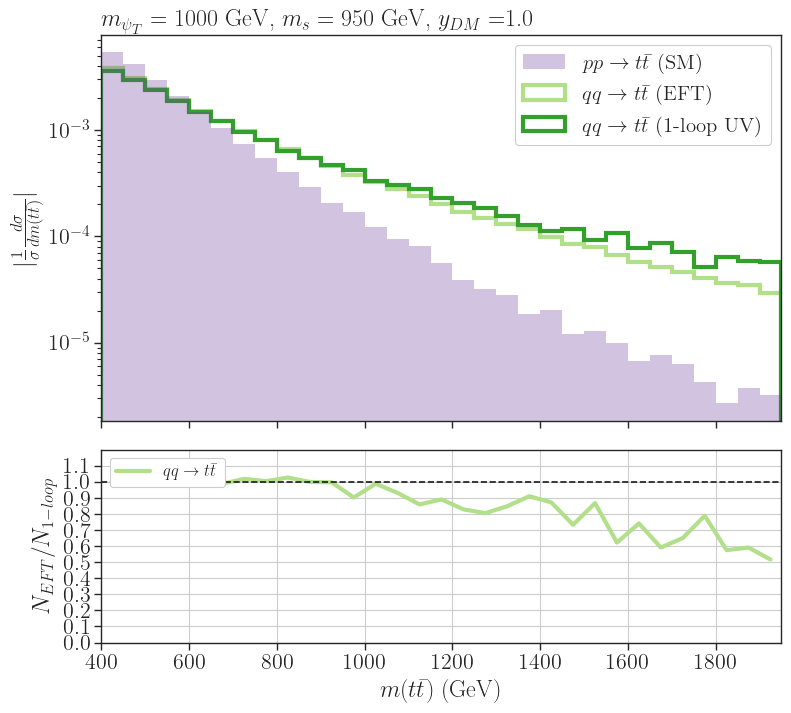

In [26]:
#Generating the BSM histograms and plotting them
# Coupling value
yDM = 1.0

    
selected = data_s

#Defining the space for the two plots 
_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

#Variables used to store hist info
labels = []
pmodels = []
hists = []
histsErr = []
c = []
mPsiT,mSDM = selected[0]['mass_params']
#Defining the binning according to the BSM masses

bins = np.arange(400.,2000.,50.)

#Loop over the processes and models

#SM plot
labels_sm = []
pmodels = []
hists_sm = []
histsErr_sm = []

for d in data_sm:
    process = d['process']
    model = d['model']
    weights = d['weights']
    pmodels.append(r'%s (%s)' %(process,model))
    label = pmodels[-1]
    labels_sm.append(label)
    h,_ = np.histogram(d['mTT'],bins=bins,weights=d['weights'])
    hists_sm.append(h)
    #Compute MC error
    hErr,_ = np.histogram(d['mTT'],bins=bins,weights=(d['weights'])**2)
    hErr = np.sqrt(hErr)    
    histsErr_sm.append(hErr)
#Plotting the SM hist
axarr[0].hist(bins[:-1],weights=np.abs(hists_sm[2]),label=labels_sm[2],bins=bins,
                          color=sns.color_palette('Paired')[9],alpha=0.3,histtype='step',density=True,
                         linewidth=0,fill=True,stacked=True,linestyle='solid')  

    
for j,d in enumerate(selected):
    if r'$g g \to t \bar{t}$' in d['process']:
        labels.append('0')
        c.append('0')
        continue
    else:
        process = d['process']
        model = d['model']
        weights = d['weights']
        pmodels.append(r'%s (%s)' %(process,model))
        label = pmodels[-1]
        labels.append(label)
        c.append(selectColor(model,process))
        h,_ = np.histogram(d['mTT'],bins=bins,weights=d['weights'])
        hists.append(h)
        #Compute MC error
        hErr,_ = np.histogram(d['mTT'],bins=bins,weights=(d['weights'])**2)
        hErr = np.sqrt(hErr)    
        histsErr.append(hErr)
        #Plotting the BSM hists
        axarr[0].hist(bins[:-1],weights=abs(h),label=labels[j],bins=bins,
                              color=c[j],alpha=1.0,histtype='step',density=True,
                             linewidth=3,fill=False,zorder=i,linestyle='solid')
    

#Ratio plot
# Separating the EFT and the 1-loop UV results
hLoop = hists[1]
hEFT = hists[0]
#Computing the ratio EFT/1-loop UV
labels_r = [r'$q q \to t \bar{t}$']
    
ratio = np.divide(hEFT/sum(hEFT) , hLoop/sum(hLoop), out=np.zeros_like(hLoop),where=hLoop != 0)
# Remove zero values
nonzero = np.where((np.sign(ratio) != 0))
x = (bins[:-1]+bins[1:])/2.0
y = ratio
label = labels_r[0]
#Ratio plots
axarr[1].plot(x,y,linewidth=3.0,linestyle='solid',alpha=1,
                              label=label,c=c[0])
        
#Main plot configs
axarr[0].legend(framealpha=1.0,loc='upper right',fontsize=15)
axarr[0].set_title(r'$m_{\psi_T} = %1.0f$ GeV, $m_{s} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mPsiT,mSDM,yDM),
                   loc='left')
axarr[0].set_yscale('log')
axarr[0].set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
axarr[0].set_xlim(bins.min(),bins.max())
axarr[1].set_ylabel(r'$N_{EFT}/N_{1-loop}$')
    
#Subplot configs
axarr[1].set_ylim(0,1.2)
axarr[1].set_yticks(np.arange(0,1.2,0.1))
#axarr[1].set_yscale('log')
axarr[1].grid()
axarr[1].axhline(y=1, color='k', linestyle='--')
axarr[1].legend(loc='upper left',fontsize=12,framealpha=1.0,ncol=2)
axarr[1].set_xlabel(r'$m(t\bar{t})$ (GeV)')
    
plt.show()


# $p_T$ $qq\to t\bar{t}$

In [ ]:
#Generating the BSM histograms and plotting them
# Coupling value
yDM = 1.0

    
selected = data_s

#Defining the space for the two plots 
_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

#Variables used to store hist info
labels = []
pmodels = []
hists = []
histsErr = []
c = []
mPsiT,mSDM = selected[0]['mass_params']
#Defining the binning according to the BSM masses

bins = np.arange(400.,2000.,50.)

#Loop over the processes and models

#SM plot
labels_sm = []
pmodels = []
hists_sm = []
histsErr_sm = []

for d in data_sm:
    process = d['process']
    model = d['model']
    weights = d['weights']
    pmodels.append(r'%s (%s)' %(process,model))
    label = pmodels[-1]
    labels_sm.append(label)
    h,_ = np.histogram(d['pT'],bins=bins,weights=d['weights'])
    hists_sm.append(h)
    #Compute MC error
    hErr,_ = np.histogram(d['pT'],bins=bins,weights=(d['weights'])**2)
    hErr = np.sqrt(hErr)    
    histsErr_sm.append(hErr)
#Plotting the SM hist
axarr[0].hist(bins[:-1],weights=np.abs(hists_sm[2]),label=labels_sm[2],bins=bins,
                          color=sns.color_palette('Paired')[9],alpha=0.3,histtype='step',density=True,
                         linewidth=0,fill=True,stacked=True,linestyle='solid')  

    
for j,d in enumerate(selected):
    if r'$g g \to t \bar{t}$' in d['process']:
        labels.append('0')
        c.append('0')
        continue
    else:
        process = d['process']
        model = d['model']
        weights = d['weights']
        pmodels.append(r'%s (%s)' %(process,model))
        label = pmodels[-1]
        labels.append(label)
        c.append(selectColor(model,process))
        h,_ = np.histogram(d['pT'],bins=bins,weights=d['weights'])
        hists.append(h)
        #Compute MC error
        hErr,_ = np.histogram(d['pT'],bins=bins,weights=(d['weights'])**2)
        hErr = np.sqrt(hErr)    
        histsErr.append(hErr)
        #Plotting the BSM hists
        axarr[0].hist(bins[:-1],weights=abs(h),label=labels[j],bins=bins,
                              color=c[j],alpha=1.0,histtype='step',density=True,
                             linewidth=3,fill=False,zorder=i,linestyle='solid')
    

#Ratio plot
# Separating the EFT and the 1-loop UV results
hLoop = hists[1]
hEFT = hists[0]
#Computing the ratio EFT/1-loop UV
labels_r = [r'$q q \to t \bar{t}$']
    
ratio = np.divide(hEFT/sum(hEFT) , hLoop/sum(hLoop), out=np.zeros_like(hLoop),where=hLoop != 0)
# Remove zero values
nonzero = np.where((np.sign(ratio) != 0))
x = (bins[:-1]+bins[1:])/2.0
y = ratio
label = labels_r[0]
#Ratio plots
axarr[1].plot(x,y,linewidth=3.0,linestyle='solid',alpha=1,
                              label=label,c=c[0])
        
#Main plot configs
axarr[0].legend(framealpha=1.0,loc='upper right',fontsize=15)
axarr[0].set_title(r'$m_{\psi_T} = %1.0f$ GeV, $m_{s} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mPsiT,mSDM,yDM),
                   loc='left')
axarr[0].set_yscale('log')
axarr[0].set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
axarr[0].set_xlim(bins.min(),bins.max())
axarr[1].set_ylabel(r'$N_{EFT}/N_{1-loop}$')
    
#Subplot configs
axarr[1].set_ylim(-1,1.5)
#axarr[1].set_yticks(np.arange(-0.01,0.05,0.01))
#axarr[1].set_yscale('log')
axarr[1].grid()
axarr[1].axhline(y=1, color='k', linestyle='--')
axarr[1].legend(loc='upper left',fontsize=12,framealpha=1.0,ncol=2)
axarr[1].set_xlabel(r'$pT(t)$ (GeV)')
    
plt.show()

# $qq\to t\bar{t}$

In [ ]:
files = list(glob.glob('/home/vinicius/EFT_ToyModel/processFolders/*/gg2ttbar_gs4_ydm2/Events/run_Stest/*events.lhe.gz'))
data_s = []
for i,f in enumerate(files):
    d = getDistributions(f)
    if i == 0:
        d = AddInfoToDistributions(d,'TopEFT','gg2ttbar_gs4_ydm2', 2000., 1900.)
    else:
        d = AddInfoToDistributions(d,'UV_BSM','gg2ttbar_gs4_ydm2', 2000., 1900.)
    data_s.append(d)


In [ ]:
print(files)

In [ ]:
#Generating the BSM histograms and plotting them
# Coupling value
yDM = 1.0

    
selected = data_s

#Defining the space for the two plots 
_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

#Variables used to store hist info
labels = []
pmodels = []
hists = []
histsErr = []
c = []
mPsiT,mSDM = selected[0]['mass_params']
#Defining the binning according to the BSM masses

bins = np.arange(400.,2000.,75.)

#Loop over the processes and models

#SM plot
labels_sm = []
pmodels = []
hists_sm = []
histsErr_sm = []

for d in data_sm:
    process = d['process']
    model = d['model']
    weights = d['weights']
    pmodels.append(r'%s (%s)' %(process,model))
    label = pmodels[-1]
    labels_sm.append(label)
    h,_ = np.histogram(d['mTT'],bins=bins,weights=d['weights'])
    hists_sm.append(h)
    #Compute MC error
    hErr,_ = np.histogram(d['mTT'],bins=bins,weights=(d['weights'])**2)
    hErr = np.sqrt(hErr)    
    histsErr_sm.append(hErr)
#Plotting the SM hist
axarr[0].hist(bins[:-1],weights=np.abs(hists_sm[2]),label=labels_sm[2],bins=bins,
                          color=sns.color_palette('Paired')[9],alpha=0.3,histtype='step',density=True,
                         linewidth=0,fill=True,stacked=True,linestyle='solid')  

    
for j,d in enumerate(selected):
    if r'$q q \to t \bar{t}$' in d['process']:
        labels.append('0')
        c.append('0')
        continue
    else:
        process = d['process']
        model = d['model']
        weights = d['weights']
        pmodels.append(r'%s (%s)' %(process,model))
        label = pmodels[-1]
        labels.append(label)
        c.append(selectColor(model,process))
        h,_ = np.histogram(d['mTT'],bins=bins,weights=d['weights'])
        hists.append(h)
        #Compute MC error
        hErr,_ = np.histogram(d['mTT'],bins=bins,weights=(d['weights'])**2)
        hErr = np.sqrt(hErr)    
        histsErr.append(hErr)
        #Plotting the BSM hists
        axarr[0].hist(bins[:-1],weights=abs(h),label=labels[j],bins=bins,
                              color=c[j],alpha=1.0,histtype='step',density=True,
                             linewidth=3,fill=False,zorder=i,linestyle='solid')
    

#Ratio plot
# Separating the EFT and the 1-loop UV results
hLoop = hists[1]
hEFT = hists[0]
#Computing the ratio EFT/1-loop UV
labels_r = [r'$g g \to t \bar{t}$']
    
ratio = np.divide(hEFT/sum(hEFT) , hLoop/sum(hLoop), out=np.zeros_like(hLoop),where=hLoop != 0)
# Remove zero values
nonzero = np.where((np.sign(ratio) != 0))
x = (bins[:-1]+bins[1:])/2.0
y = ratio
label = labels_r[0]
#Ratio plots
axarr[1].plot(x,y,linewidth=3.0,linestyle='solid',alpha=1,
                              label=label,c=c[0])
        
#Main plot configs
axarr[0].legend(framealpha=1.0,loc='upper right',fontsize=15)
axarr[0].set_title(r'$m_{\psi_T} = %1.0f$ GeV, $m_{s} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mPsiT,mSDM,yDM),
                   loc='left')
axarr[0].set_yscale('log')
axarr[0].set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
axarr[0].set_xlim(bins.min(),bins.max())
axarr[1].set_ylabel(r'$N_{EFT}/N_{1-loop}$')
    
#Subplot configs
axarr[1].set_ylim(0,1.2)
axarr[1].set_yticks(np.arange(0,1.2,0.1))
#axarr[1].set_yscale('log')
axarr[1].grid()
axarr[1].axhline(y=1, color='k', linestyle='--')
axarr[1].legend(loc='upper left',fontsize=12,framealpha=1.0,ncol=2)
axarr[1].set_xlabel(r'$m(t\bar{t})$ (GeV)')
    
plt.show()

In [ ]:
#Generating the BSM histograms and plotting them
# Coupling value
yDM = 1.0

    
selected = data_s

#Defining the space for the two plots 
_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

#Variables used to store hist info
labels = []
pmodels = []
hists = []
histsErr = []
c = []
mPsiT,mSDM = selected[0]['mass_params']
#Defining the binning according to the BSM masses

bins = np.arange(500.,2000.,100.)

#Loop over the processes and models

#SM plot
labels_sm = []
pmodels = []
hists_sm = []
histsErr_sm = []

for d in data_sm:
    process = d['process']
    model = d['model']
    weights = d['weights']
    pmodels.append(r'%s (%s)' %(process,model))
    label = pmodels[-1]
    labels_sm.append(label)
    h,_ = np.histogram(d['pT'],bins=bins,weights=d['weights'])
    hists_sm.append(h)
    #Compute MC error
    hErr,_ = np.histogram(d['pT'],bins=bins,weights=(d['weights'])**2)
    hErr = np.sqrt(hErr)    
    histsErr_sm.append(hErr)
#Plotting the SM hist
axarr[0].hist(bins[:-1],weights=np.abs(hists_sm[2]),label=labels_sm[2],bins=bins,
                          color=sns.color_palette('Paired')[9],alpha=0.3,histtype='step',density=True,
                         linewidth=0,fill=True,stacked=True,linestyle='solid')  

    
for j,d in enumerate(selected):
    if r'$q q \to t \bar{t}$' in d['process']:
        labels.append('0')
        c.append('0')
        continue
    else:
        process = d['process']
        model = d['model']
        weights = d['weights']
        pmodels.append(r'%s (%s)' %(process,model))
        label = pmodels[-1]
        labels.append(label)
        c.append(selectColor(model,process))
        h,_ = np.histogram(d['pT'],bins=bins,weights=d['weights'])
        hists.append(h)
        #Compute MC error
        hErr,_ = np.histogram(d['pT'],bins=bins,weights=(d['weights'])**2)
        hErr = np.sqrt(hErr)    
        histsErr.append(hErr)
        #Plotting the BSM hists
        axarr[0].hist(bins[:-1],weights=abs(h),label=labels[j],bins=bins,
                              color=c[j],alpha=1.0,histtype='step',density=True,
                             linewidth=3,fill=False,zorder=i,linestyle='solid')
    

#Ratio plot
# Separating the EFT and the 1-loop UV results
hLoop = hists[1]
hEFT = hists[0]
#Computing the ratio EFT/1-loop UV
labels_r = [r'$g g \to t \bar{t}$']
    
ratio = np.divide(hEFT/sum(hEFT) , hLoop/sum(hLoop), out=np.zeros_like(hLoop),where=hLoop != 0)
# Remove zero values
nonzero = np.where((np.sign(ratio) != 0))
x = (bins[:-1]+bins[1:])/2.0
y = ratio
label = labels_r[0]
#Ratio plots
axarr[1].plot(x,y,linewidth=3.0,linestyle='solid',alpha=1,
                              label=label,c=c[0])
        
#Main plot configs
axarr[0].legend(framealpha=1.0,loc='upper right',fontsize=15)
axarr[0].set_title(r'$m_{\psi_T} = %1.0f$ GeV, $m_{s} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mPsiT,mSDM,yDM),
                   loc='left')
axarr[0].set_yscale('log')
axarr[0].set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
axarr[0].set_xlim(bins.min(),bins.max())
axarr[1].set_ylabel(r'$N_{EFT}/N_{1-loop}$')
    
#Subplot configs
axarr[1].set_ylim(-1,1.5)
#axarr[1].set_yticks(np.arange(-0.01,0.05,0.01))
#axarr[1].set_yscale('log')
axarr[1].grid()
axarr[1].axhline(y=1, color='k', linestyle='--')
axarr[1].legend(loc='upper left',fontsize=12,framealpha=1.0,ncol=2)
axarr[1].set_xlabel(r'$pT(t)$ (GeV)')
    
plt.show()